In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [2]:
df_data = pd.read_excel(r"datos/Datos_proyecto.xlsx")
df_data.head()
df = df_data.dropna(subset=["textos", "labels"])
df = df.drop_duplicates(subset=["textos", "labels"])

wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()


def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [
        spanish_stemmer.stem(token) if stem else token
        for token in tokens
        if token not in stop_words
    ]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)


normalized_df.head()


,textos,labels,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


In [29]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)


In [30]:
def logistic_n_gram(n_grama_param, X_train, X_test, y_train, y_test):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test.fillna(""))

    # Modelo
    log_n = LogisticRegression(max_iter=1000, random_state=42)
    log_n.fit(X_train_ngram, y_train)
    y_pred = log_n.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred, average="macro"))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))

logistic_n_gram((1, 1), X_train_text, X_test_text, y_train, y_test)

N-grama (1, 1):
F1 score: 0.9712130330842402
Precision: 0.974286810311103
Recall: 0.9686968049298327
              precision    recall  f1-score   support

           1       0.97      0.93      0.95        82
           3       0.96      0.99      0.98       125
           4       0.99      0.99      0.99       157

    accuracy                           0.98       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.98      0.98      0.98       364



In [3]:
df2 = pd.read_excel(r"datos/Datos_aumentados_train.xlsx")
df2.shape

(2214, 2)

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import FunctionTransformer


In [3]:
df = pd.read_excel(r"datos/Datos_proyecto.xlsx")

In [9]:
pd.set_option('display.max_colwidth', None)

In [47]:
X = df["textos"]
y = df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
import cloudpickle
from sklearn.pipeline import Pipeline
import WordTokenizer
from WordTokenizer import WordTokenizerTransformer

X = df["textos"]
y = df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tokenizer = WordTokenizerTransformer()
#df_token = tokenizer.fit_transform(X_train_text)

pipeline = Pipeline([
    ('tokenize', tokenizer),
    ('vectorizer', CountVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train_text, y_train)

# Evaluar
y_pred = pipeline.predict(X_test_text)

cloudpickle.register_pickle_by_value(WordTokenizer)

#with open('pipeline.cloudpkl', mode='wb') as file:
    #cloudpickle.dump(pipeline, file)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.97409148364418
Recall:  0.9706410371937214
F1 Score:  0.9721977831629459
              precision    recall  f1-score   support

           1       0.97      0.94      0.96       157
           3       0.96      0.99      0.97       255
           4       0.99      0.98      0.99       316

    accuracy                           0.98       728
   macro avg       0.97      0.97      0.97       728
weighted avg       0.98      0.98      0.98       728



## Metodos de reentrenamiento 
A continuación, se revisan diferentes métodos de reentrenamiento analizando sus ventajas y desventajas y decidiendo cuál implementar dentro del modelo final.
### Método 1: Reentrenamiento completo
Este método consiste en tomar las nuevas instancias y reentrenar todo el modelo al unir los sets de datos. Entre las ventajas de este método se incluye que permite un aprendizaje completo del modelo, lo que lo puede hacer más robusto frente a diferentes casos. Sin embargo, entre sus desventajas se reslata que requiere más tiempo y tiene un costo computacional más elevado, lo que dependiendo de la aplicación puede no ser deseado. 
A continuación, se utilizan unos datos adicionales para modelar las diferentes formas en las qu se realiza el reentrenamiento para comparar adecuadamente el desarrollo. 

In [34]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")

In [35]:
df_og = pd.read_excel(r"datos\Datos_proyecto.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9822027112167957
Recall:  0.9841765836502678
F1 Score:  0.983171654626763
              precision    recall  f1-score   support

           1       0.97      0.99      0.98        76
           3       0.99      0.99      0.99       150
           4       0.99      0.98      0.98       143

    accuracy                           0.98       369
   macro avg       0.98      0.98      0.98       369
weighted avg       0.98      0.98      0.98       369



### Método 2: Reentrenamiento incremental

Algunos tipos de modelos permiten un reentrenamiento parcial en donde se procesa sobre los datos nuevos nada más. Esto resulta útil para modelos que no tengan los recursos para soportar un entrenamiento completo, o requieran aplicaciones más rápidas en tiempo. Sin embargo, una de las desventajas de este método es que no todos los modelos lo soportan. En particular, `Logistic Regression` no soporta este tipo de reentrenamiento a diferencia de modelos como `SGDClassifier` y `PassiveAggressiveClassifier` lo cual lo hace incompatible para este caso. 

In [45]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")
df_og = pd.read_excel(r"datos\Datos_proyecto.xlsx")

tokenizer = WordTokenizerTransformer()

pipeline = Pipeline([
    ('tokenize', tokenizer),
    ('vectorizer', CountVectorizer(ngram_range=(1,1)))
])

X = pipeline.fit_transform(df_og["textos"])  
y = df_og["labels"]

model = SGDClassifier(loss='log_loss', max_iter=1000)


X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model.partial_fit(X_train_text, y_train, classes=np.unique(y_train))
y_pred = model.predict(X_test_text)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

X_new = pipeline.transform(df_nuevo["textos"])  
y_new = df_nuevo["labels"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

model.partial_fit(X_new, y_new)

y_pred = model.predict(X_test_new)

precision = precision_score(y_test_new, y_pred, average="macro")
recall = recall_score(y_test_new, y_pred, average="macro")
f1 = f1_score(y_test_new, y_pred, average="macro")
report = classification_report(y_test_new, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)



Precision:  0.957105618395941
Recall:  0.9558917329193495
F1 Score:  0.9563438848957984
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       157
           3       0.94      0.97      0.96       255
           4       0.98      0.97      0.97       316

    accuracy                           0.96       728
   macro avg       0.96      0.96      0.96       728
weighted avg       0.96      0.96      0.96       728

Precision:  0.9166666666666666
Recall:  0.8333333333333334
F1 Score:  0.8412698412698413
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         4

    accuracy                           0.89         9
   macro avg       0.92      0.83      0.84         9
weighted avg       0.92      0.89      0.88         9



### Método 3: Ventanas de tiempo
En algunos contextos resulta útil e interesante utilizar un reentrenamiento con ventanas de tiempo. Esto significa que se van eliminando los datos más viejos y se mantienen los nuevos. Esto tiene sentido para problemas en los que el comportamiento de las distribuciones cambia y se presentan situaciones cambiantes con el tiempo que pueden no ser representadas correctamente a partir de los datos nuevos. 
En este problema en particular, siempre se desea clasificar los datos entre 3 ODS que no cambian de definición. Esto hace que el uso de ventanas de tiempo no sea necesariamente el más adecuado. Es así como una de las ventajas de este método es que permite adaptarse mejor a los nuevos datos y darles más relevancia, lo que ayuda cuando cambian los patrones a lo largo del tiempo. Sin embargo, una de las desventajas de este método es que si los patrones no cambian, se puede llegar a perder información útil para el desempeño del modelo. 
Para la implementación de este caso, se eliminarán datos viejos y se agregaran nuevos. Se eliminan los n datos nuevos que se agreguen por clase. 

In [36]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")
df_og = pd.read_excel(r"datos\Datos_proyecto.xlsx")

df_og_filtrado = df_og.copy()

for label, group in df_nuevo.groupby('labels'):
    n_nuevos = len(group)
    # Filtrar registros viejos de esa clase
    mask_clase = df_og_filtrado['labels'] == label
    indices_clase = df_og_filtrado[mask_clase].index

    # Eliminar los primeros n registros viejos de esa clase
    if len(indices_clase) >= n_nuevos:
        indices_a_eliminar = indices_clase[:n_nuevos]
        df_og_filtrado = df_og_filtrado.drop(indices_a_eliminar)
    
df_unified = pd.concat([df_nuevo, df_og_filtrado], ignore_index=True)

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)


Precision:  0.969726525601924
Recall:  0.9594049574410924
F1 Score:  0.9641452359224053
              precision    recall  f1-score   support

           1       0.99      0.92      0.95        76
           3       0.95      0.97      0.96       134
           4       0.97      0.99      0.98       154

    accuracy                           0.97       364
   macro avg       0.97      0.96      0.96       364
weighted avg       0.97      0.97      0.97       364



### Método 4: Reentrenamiento completo con ajuste de peso
Finalmente, se propone nuevamente el uso de reentrenamiento completo del modelo pero se usa un ajuste de pesos dentro del modelo. La ventaja de esto es que además de usar todos los datos, ajusta el peso de clases para responder frente a casos en los que se genere desbalanceo de clases. Esto puede ayudar a que si los datos nuevos generan un desbalance, el modelo compense este comportamiento automáticamente. Sin embargo, las desventajas de la implementación original se mantienen ya que al ser un reentrenamiento completo es computacionalmente complejo. 




#### Propuesta sin ajuste de peso

In [33]:
df_nuevo = pd.read_csv(r"datos\datos_ods4_100.csv")
df_og = pd.read_excel(r"datos\Datos_proyecto.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9802589268238123
Recall:  0.9666098081023454
F1 Score:  0.9729876856402938
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        70
           3       0.98      0.96      0.97       134
           4       0.96      0.99      0.97       175

    accuracy                           0.97       379
   macro avg       0.98      0.97      0.97       379
weighted avg       0.97      0.97      0.97       379



#### Propuesta con ajuste de peso

In [28]:
df_nuevo = pd.read_csv(r"datos\datos_ods4_100.csv")
df_nuevo.head()

,textos,labels
0,La educación gratuita y de calidad es un derec...,4
1,Los estudiantes deben aprender habilidades soc...,4
2,La calidad docente es el pilar de una buena ed...,4
3,Las evaluaciones deben centrarse en el aprendi...,4
4,La cooperación internacional puede fortalecer ...,4


In [29]:
df_og = pd.read_excel(r"datos\Datos_proyecto.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

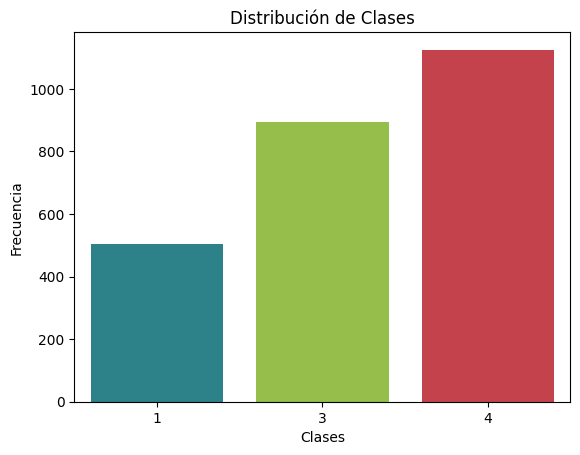

In [30]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}
value_counts = df_unified["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [32]:
with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

classifier = model.named_steps["classifier"]
classifier.set_params(class_weight='balanced')

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9752446558416707
Recall:  0.9641222459132907
F1 Score:  0.9693301784327977
              precision    recall  f1-score   support

           1       0.99      0.94      0.96        70
           3       0.98      0.96      0.97       134
           4       0.96      0.99      0.97       175

    accuracy                           0.97       379
   macro avg       0.98      0.96      0.97       379
weighted avg       0.97      0.97      0.97       379

